In [109]:
import pandas as pd 
import numpy as np 
import configparser
import os
import seaborn as sns
import plotly_express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk 

config = configparser.ConfigParser()
config.read("env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
base_path = config['DEFAULT']['base_path']
code_dir = config['DEFAULT']['code_dir']

data_prefix = 'Maha'
out_path = f'{output_dir}/{data_prefix}'
OHCO = ['book_id','chap_id','sec_id','para_num', 'sent_num', 'token_num']


os.chdir(code_dir)
import preprocess
import bow_analysis
os.chdir(base_path)

SENTS = OHCO[:5]
PARA = OHCO[:4]
SECS = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [110]:
CORPUS = pd.read_csv(fr"{output_dir}\F3\{data_prefix}-CORPUS.csv", sep="|").set_index(OHCO)
LIB = pd.read_csv(fr"{output_dir}\F3\{data_prefix}-LIB.csv", sep="|").set_index('book_id')
LIB2 = pd.read_csv(fr"{output_dir}\F3\{data_prefix}-LIB2.csv", sep="|").set_index(OHCO[:2])

BOW = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-BOW-CHAPS.csv", sep="|").set_index(OHCO[:2] + ['term_str'])
VOCAB = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-VOCAB2.csv", sep="|").set_index('term_str')
TFIDF = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-TFIDF_REDUCED_CHAPS_L2.csv", sep="|").set_index(OHCO[:2])

In [111]:
BOW

n        tf     tfidf
book_id chap_id term_str                            
1       1       a             57  0.007589  0.000000
                abhimanyu      2  0.000266  0.000368
                abikshit       1  0.000133  0.000883
                able           4  0.000533  0.000135
                abode          5  0.000666  0.000135
...                           ..       ...       ...
18      1       your           5  0.000580  0.000210
                yours          1  0.000116  0.000189
                yourself       1  0.000116  0.000443
                yudhamanyu     1  0.000116  0.000267
                yudhishthira  30  0.003477  0.000260

[245040 rows x 3 columns]

In [112]:
LIB3 = LIB2.reset_index().merge(LIB.reset_index(), on='book_id', suffixes = ["_chap","_book"])
LIB3['chapter'] = LIB3.apply(lambda x: f"{x['book_id']}.{x['chap_id']}", axis=1)
LIB3 = LIB3.set_index(OHCO[:2])
LIB3

chap_name              book_name  \
book_id chap_id                                                 
1       1           Anukramanika Parva              Adi Parva   
        2               Sangraha Parva              Adi Parva   
        3                Paushya Parva              Adi Parva   
        4                Pauloma Parva              Adi Parva   
        5                 Astika Parva              Adi Parva   
...                                ...                    ...   
15      2           Putradarsana Parva     Asramavasika Parva   
        3           Naradagamana Parva     Asramavasika Parva   
16      1                Mausala Parva          Mausala Parva   
17      1        Mahaprasthanika Parva  Mahaprasthanika Parva   
18      1         Svargarohanika Parva   Svargarohanika Parva   

                source_file_path_chap  chap_len  n_secs_chap  n_sents_chap  \
book_id chap_id                                                              
1       1                  maha01.txt      7511            1           374   
        2                  maha01.txt      8655            1           524   
        3                  maha01.txt      6137            1           396   
        4                  maha01.txt      4661            9           261   
        5                  maha01.txt     30619           46          1753   
...                               ...       ...          ...           ...   
15      2                  maha15.txt      6789            8           417   
        3                  maha15.txt      2551            3           149   
16      1                  maha16.txt      8072            7           432   
17      1                  maha17.txt      3062            2           206   
18      1                  maha18.txt      8628            5           495   

                 n_tokens_chap source_file_path_book              raw_title  \
book_id chap_id                                                               
1       1                 7511            maha01.txt              Adi Parva   
        2                 8655            maha01.txt              Adi Parva   
        3                 6137            maha01.txt              Adi Parva   
        4                 4661            maha01.txt              Adi Parva   
        5                30619            maha01.txt              Adi Parva   
...                        ...                   ...                    ...   
15      2                 6789            maha15.txt     Asramavasika Parva   
        3                 2551            maha15.txt     Asramavasika Parva   
16      1                 8072            maha16.txt          Mausala Parva   
17      1                 3062            maha17.txt  Mahaprasthanika Parva   
18      1                 8628            maha18.txt   Svargarohanika Parva   

                 book_len  ...  n_secs_book  n_sents_book  n_tokens_book  \
book_id chap_id            ...                                             
1       1          228684  ...          235         12422         228684   
        2          228684  ...          235         12422         228684   
        3          228684  ...          235         12422         228684   
        4          228684  ...          235         12422         228684   
        5          228684  ...          235         12422         228684   
...                   ...  ...          ...           ...            ...   
15      2           30376  ...           38          1742          30376   
        3           30376  ...           38          1742          30376   
16      1            8072  ...            7           432           8072   
17      1            3062  ...            2           206           3062   
18      1            8628  ...            5           495           8628   

                 n_chars       parva_name  timeline  \
book_id chap_id                                       
1       1        1055885              Adi

In [113]:
salex_csv = f'{data_home}/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [114]:
V = pd.merge(VOCAB, SALEX, how='left', on = 'term_str', indicator=True)
V._merge.value_counts()

_merge
left_only     28501
both           2181
right_only        0
Name: count, dtype: int64

In [115]:
V[V._merge=='left_only'].sort_values("dh", ascending=False).head(10).T

term_str,soft,ascending,bound,necessary,upraised,sixty,hereafter,run,trunks,aside
term_rank,2365,1895,1975,1699,2297,1702,1111,2303,1950,1711
index,24698,3571,5014,18185,28263,24431,13072,22677,27353,3612
n,87,117,111,134,90,134,231,90,113,133
n_chars,4,9,5,9,8,5,9,3,6,5
p,0.000036,0.000049,0.000046,0.000056,0.000037,0.000056,0.000096,0.000037,0.000047,0.000055
i,14.757319,14.329898,14.405846,14.134173,14.708409,14.134173,13.348513,14.708409,14.380083,14.14498
s,27694.632184,20593.444444,21706.603604,17980.843284,26771.477778,17980.843284,10430.445887,26771.477778,21322.415929,18116.037594
h,0.000533,0.000696,0.000664,0.000786,0.000549,0.000786,0.00128,0.000549,0.000674,0.000781
stop,0,0,0,0,0,0,0,0,0,0
stem_porter,soft,ascend,bound,necessari,uprais,sixti,hereaft,run,trunk,asid


In [116]:
V[(V._merge=='left_only') & 
  (V.dh >= 0.447) & 
  (V.max_pos_group.apply(lambda x: x in ['NN','VB','JJ','RB']))\
    ]\
    .sort_values("dh", ascending=False).drop(emo_cols, axis=1).T

term_str,stretched,mansion,virulent,match,ranks,mixed,marks,visible,liveth,appearance,...,fasts,bharadwajas,goes,yadu,falsely,sini,concentrated,sraddha,started,affair
term_rank,2142,1459,1476,2036,1371,1786,2593,1785,2032,1777,...,2037,1977,1954,3588,4150,1606,1600,1541,4136,6013
index,25400,17059,29243,17185,21389,17660,17122,29284,16396,3248,...,10929,4626,12243,30474,10867,24354,6698,25039,25166,2475
n,100,162,160,107,176,125,76,125,107,127,...,107,111,113,46,37,144,145,152,37,19
n_chars,9,7,8,5,5,5,5,7,6,10,...,5,11,4,4,7,4,12,7,7,6
p,0.000042,0.000067,0.000066,0.000044,0.000073,0.000052,0.000032,0.000052,0.000044,0.000053,...,0.000044,0.000046,0.000047,0.000019,0.000015,0.00006,0.00006,0.000063,0.000015,0.000008
i,14.556406,13.860412,13.878334,14.458795,13.740831,14.234478,14.952335,14.234478,14.458795,14.211578,...,14.458795,14.405846,14.380083,15.6767,15.990809,14.030337,14.020353,13.952335,15.990809,16.952335
s,24094.33,14873.04321,15058.95625,22518.065421,13689.960227,19275.464,31703.065789,19275.464,22518.065421,18971.913386,...,22518.065421,21706.603604,21322.415929,52378.978261,65119.810811,16732.173611,16616.77931,15851.532895,65119.810811,126812.263158
h,0.000604,0.000932,0.000922,0.000642,0.001004,0.000738,0.000472,0.000738,0.000642,0.000749,...,0.000642,0.000664,0.000674,0.000299,0.000246,0.000839,0.000844,0.00088,0.000246,0.000134
stop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stem_porter,stretch,mansion,virul,match,rank,mix,mark,visibl,liveth,appear,...,fast,bharadwaja,goe,yadu,fals,sini,concentr,sraddha,start,affair


In [117]:
VOCAB.dh.describe()

count    30681.000000
mean         0.180276
std          0.145670
min          0.000000
25%          0.066963
50%          0.113724
75%          0.245115
max          0.530702
Name: dh, dtype: float64

In [118]:
V = V[V['_merge']=='both'].drop("_merge", axis=1)
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
for col in emo_cols:
    B[col] = B[col] * B.tfidf
B

n        tf     tfidf max_pos     anger  \
book_id chap_id term_str                                                
1       1       abundance     1  0.000133  0.000280      NN  0.000000   
                abundant      2  0.000266  0.000339      JJ  0.000000   
                accomplished  3  0.000399  0.000208     VBN  0.000000   
                achieve       1  0.000133  0.000127      VB  0.000000   
                affection     3  0.000399  0.000216      NN  0.000000   
...                          ..       ...       ...     ...       ...   
18      1       wonderful     1  0.000116  0.000068      JJ  0.000000   
                word          3  0.000348  0.000235      NN  0.000000   
                words         9  0.001043  0.000031     NNS  0.000031   
                worship       1  0.000116  0.000078      NN  0.000000   
                wrath         5  0.000580  0.000137      NN  0.000137   

                              anticipation  disgust      fear       joy  \
book_id chap_id term_str                                                  
1       1       abundance         0.000280  0.00028  0.000000  0.000280   
                abundant          0.000000  0.00000  0.000000  0.000339   
                accomplished      0.000000  0.00000  0.000000  0.000208   
                achieve           0.000000  0.00000  0.000000  0.000127   
                affection         0.000000  0.00000  0.000000  0.000216   
...                                    ...      ...       ...       ...   
18      1       wonderful         0.000000  0.00000  0.000000  0.000068   
                word              0.000000  0.00000  0.000000  0.000000   
                words             0.000000  0.00000  0.000000  0.000000   
                worship           0.000078  0.00000  0.000078  0.000078   
                wrath             0.000000  0.00000  0.000137  0.000000   

                              sadness  surprise     trust  sentiment  
book_id chap_id term_str                                              
1       1       abundance         0.0  0.000000  0.000280   0.000000  
                abundant          0.0  0.000000  0.000000   0.000339  
                accomplished      0.0  0.000000  0.000000   0.000208  
                achieve           0.0  0.000000  0.000127   0.000127  
                affection         0.0  0.000000  0.000216   0.000216  
...                               ...       ...       ...        ...  
18      1       wonderful         0.0  0.000068  0.000068   0.000068  
                word              0.0  0.000000  0.000235   0.000235  
                words             0.0  0.000000  0.000000  -0.000031  
                worship           0.0  0.000000  0.000078   0.000078  
                wrath             0.0  0.000000  0.000000  -0.000137  

[31442 rows x 13 columns]

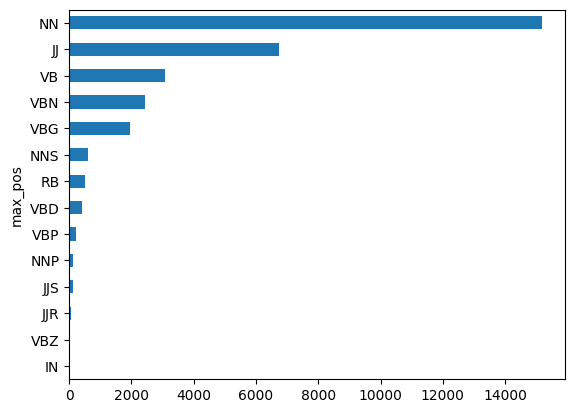

In [119]:
B.max_pos.value_counts().sort_values().plot.barh();

In [120]:
BOW_Keywords = pd.DataFrame(index = TFIDF.index) 

BOW_Keywords['Keywords'] = TFIDF.apply(
    lambda row: " ".join(row.nlargest(7).index.tolist()), axis=1)
BOW_Keywords = BOW_Keywords.reset_index()
BOW_Keywords['chapter'] = BOW_Keywords.apply(lambda x: f"{x['book_id']}.{x['chap_id']}", axis=1)
BOW_Keywords = BOW_Keywords.set_index('chapter').drop(["book_id","chap_id"], axis=1)
BOW_Keywords

,Keywords
chapter,
1.1,sanjaya hope vyasa chariot dwaipayana composed...
1.2,comes story history composed described vyasa i...
1.3,serpents aswins earrings wheel queen alms prec...
1.4,bhrigu rakshasa serpent curse agni ceremonies ...
1.5,kasyapa amrita garuda skies spake bird snake
...,...
15.2,penances vyasa gandhari deities fatherinlaw la...
15.3,gandhari sanjaya burnt fie conflagration retre...
16.1,vrishnis andhakas vrishni robbers ladies rama ...


In [121]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_id'])[emo_cols].mean()
EMO_CHAPS.index = LIB3.chapter
EMO_BOOKS.index = LIB.raw_title

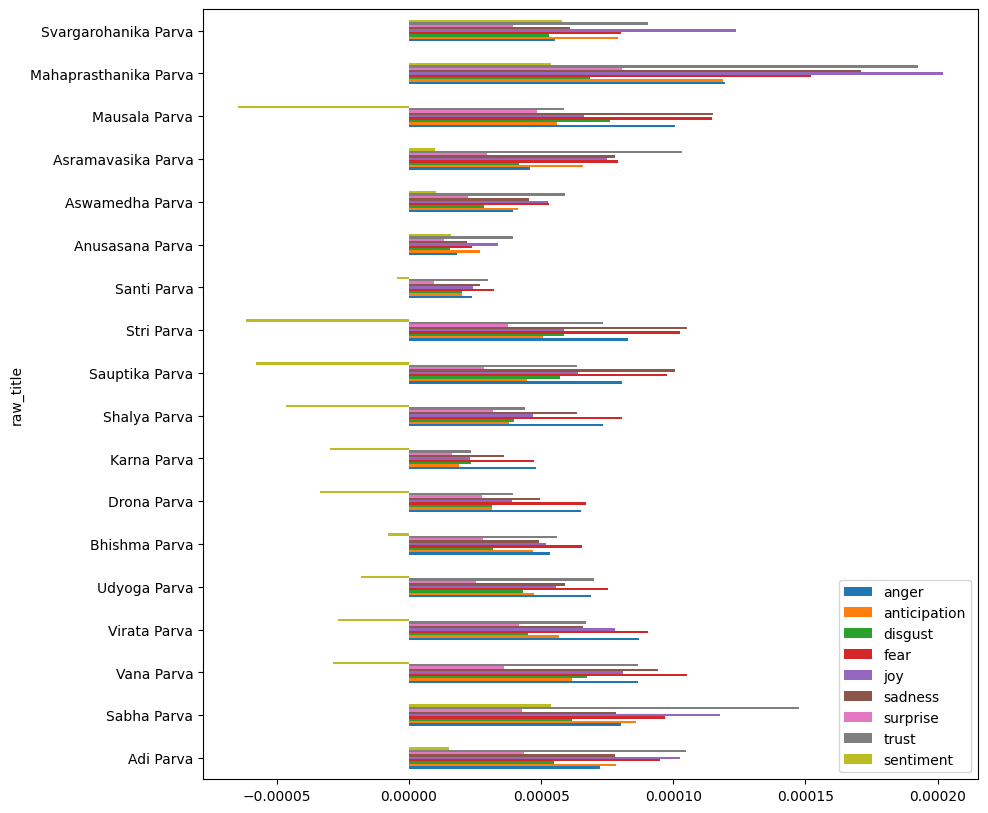

In [122]:
EMO_BOOKS.plot.barh(figsize=(10,10));

In [123]:
EMO_BOOKS.style.background_gradient(cmap='YlGnBu', axis=None)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
raw_title,,,,,,,,,
Adi Parva,0.000072,0.000078,0.000055,0.000095,0.000103,0.000078,0.000043,0.000105,0.000015
Sabha Parva,0.000080,0.000086,0.000062,0.000097,0.000118,0.000079,0.000043,0.000148,0.000054
Vana Parva,0.000087,0.000062,0.000067,0.000105,0.000081,0.000094,0.000036,0.000087,-0.000029
Virata Parva,0.000087,0.000057,0.000045,0.000090,0.000078,0.000066,0.000042,0.000067,-0.000027
Udyoga Parva,0.000069,0.000047,0.000043,0.000075,0.000056,0.000059,0.000025,0.000070,-0.000018
Bhishma Parva,0.000053,0.000047,0.000032,0.000065,0.000052,0.000049,0.000028,0.000056,-0.000008
Drona Parva,0.000065,0.000031,0.000032,0.000067,0.000039,0.000050,0.000028,0.000039,-0.000034
Karna Parva,0.000048,0.000019,0.000023,0.000047,0.000023,0.000036,0.000016,0.000023,-0.000030
Shalya Parva,0.000073,0.000038,0.000040,0.000080,0.000047,0.000064,0.000032,0.000044,-0.000047


In [124]:
EMO_CHAPS

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
chapter,,,,,,,,,
1.1,0.000076,0.000134,0.000051,0.000084,0.000157,0.000082,0.000081,0.000161,0.000090
1.2,0.000090,0.000098,0.000071,0.000118,0.000091,0.000109,0.000046,0.000108,-0.000050
1.3,0.000087,0.000125,0.000113,0.000131,0.000144,0.000145,0.000064,0.000203,0.000008
1.4,0.000135,0.000190,0.000142,0.000224,0.000220,0.000165,0.000066,0.000230,0.000032
1.5,0.000047,0.000033,0.000038,0.000058,0.000035,0.000049,0.000017,0.000042,-0.000031
...,...,...,...,...,...,...,...,...,...
15.2,0.000045,0.000088,0.000038,0.000071,0.000104,0.000090,0.000038,0.000116,0.000051
15.3,0.000121,0.000150,0.000120,0.000215,0.000141,0.000196,0.000067,0.000241,-0.000101
16.1,0.000101,0.000056,0.000076,0.000114,0.000066,0.000115,0.000048,0.000059,-0.000065


In [125]:
LONG_EMO_CHAPS = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_1':'emo'})
LONG_EMO_CHAPS = LONG_EMO_CHAPS.merge(BOW_Keywords.reset_index(), on="chapter")
LONG_EMO_CHAPS

,chapter,emo,value,Keywords
0,1.1,anger,0.000076,sanjaya hope vyasa chariot dwaipayana composed...
1,1.1,anticipation,0.000134,sanjaya hope vyasa chariot dwaipayana composed...
2,1.1,disgust,0.000051,sanjaya hope vyasa chariot dwaipayana composed...
3,1.1,fear,0.000084,sanjaya hope vyasa chariot dwaipayana composed...
4,1.1,joy,0.000157,sanjaya hope vyasa chariot dwaipayana composed...
...,...,...,...,...
886,18.1,joy,0.000124,deities felicity cleansed listening messenger ...
887,18.1,sadness,0.000061,deities felicity cleansed listening messenger ...
888,18.1,surprise,0.000040,deities felicity cleansed listening messenger ...
889,18.1,trust,0.000090,deities felicity cleansed listening messenger ...


In [126]:
px.line(LONG_EMO_CHAPS, x='chapter', y='value', color='emo', hover_data="Keywords")

In [127]:
px.line(LONG_EMO_CHAPS[LONG_EMO_CHAPS['emo']=='fear'], x='chapter', y='value', color='emo')

In [128]:
TFIDF

shafts   pierced      army   deities  carwarriors  \
book_id chap_id                                                        
1       1        0.000000  0.017978  0.029045  0.000000     0.000000   
        2        0.000000  0.006462  0.037584  0.009168     0.000000   
        3        0.000000  0.000000  0.000000  0.013734     0.000000   
        4        0.000000  0.009420  0.000000  0.000000     0.000000   
        5        0.000000  0.020106  0.000000  0.032600     0.000000   
...                   ...       ...       ...       ...          ...   
15      2        0.000000  0.000000  0.000000  0.226051     0.013851   
        3        0.017530  0.000000  0.000000  0.000000     0.000000   
16      1        0.062153  0.014705  0.000000  0.041726     0.086291   
17      1        0.000000  0.000000  0.000000  0.201742     0.000000   
18      1        0.000000  0.000000  0.000000  0.296294     0.059203   

                   troops   sanjaya       cut  penances    partha  ...  \
book_id chap_id                                                    ...   
1       1        0.000000  0.674489  0.000000  0.000000  0.000000  ...   
        2        0.050112  0.049816  0.000000  0.000000  0.000000  ...   
        3        0.000000  0.000000  0.000000  0.000000  0.000000  ...   
        4        0.000000  0.000000  0.000000  0.022543  0.000000  ...   
        5        0.000000  0.000000  0.016690  0.099664  0.000000  ...   
...                   ...       ...       ...       ...       ...  ...   
15      2        0.030889  0.000000  0.000000  0.317740  0.000000  ...   
        3        0.000000  0.374090  0.000000  0.111660  0.000000  ...   
16      1        0.014255  0.000000  0.000000  0.035190  0.058821  ...   
17      1        0.000000  0.000000  0.000000  0.042535  0.017775  ...   
18      1        0.000000  0.000000  0.010552  0.043458  0.000000  ...   

                 propitiatory  apartment  anguish    thorn  cheered  \
book_id chap_id                                                       
1       1                 0.0   0.000000  0.01683  0.00000      0.0   
        2                 0.0   0.000000  0.00000  0.00000      0.0   
        3                 0.0   0.000000  0.00000  0.00000      0.0   
        4                 0.0   0.054643  0.00000  0.00000      0.0   
        5                 0.0   0.000000  0.00000  0.00833      0.0   
...                       ...        ...      ...      ...      ...   
15      2                 0.0   0.000000  0.00000  0.00000      0.0   
        3                 0.0   0.000000  0.00000  0.00000      0.0   
16      1                 0.0   0.000000  0.00000  0.00000      0.0   
17      1                 0.0   0.000000  0.00000  0.00000      0.0   
18      1                 0.0   0.000000  0.00000  0.00000      0.0   

                 believing     tops  pressing       hid    affair  
book_id chap_id                                                    
1       1              0.0  0.00000   0.00000  0.000000  0.000000  
        2              0.0  0.00000   0.00000  0.000000  0.000000  
        3              0.0  0.00000   0.00000  0.000000  0.000000  
        4              0.0  0.00000   0.00000  0.000000  0.027321  
        5              0.0  0.00833   0.00833  0.008066  0.000000  
...                    ...      ...       ...       ...       ...  
15      2              0.0  0.00000   0.00000  0.000000  0.000000  
        3              0.0  0.00000   0.00000  0.000000  0.000000  
16      1              0.0  0.00000   0.00000  0.000000  0.000000  
17      1              0.0  0.00000   0.00000  0.000000  0.000000  
18      1              0.0  0.00000   0.00000  0.000000  0.000000  

[99 rows x 3080 columns]

In [129]:
T.dtypes

book_id             int64
chap_id             int64
sec_id              int64
para_num            int64
sent_num            int64
token_num           int64
pos_tuple          object
pos                object
token_str          object
term_str           object
pos_group          object
term_rank           int64
index               int64
n                   int64
n_chars             int64
p                 float64
i                 float64
s                 float64
h                 float64
stop                int64
stem_porter        object
stem_snowball      object
stem_lancaster     object
max_pos            object
max_pos_group      object
n_pos_group         int64
cat_pos_group      object
n_pos               int64
cat_pos            object
df                float64
idf               float64
dp                float64
di                float64
dh                float64
dfidf             float64
tfidf_mean        float64
tfidf_sum         float64
anger             float64
anticipation

In [134]:
CORPUS = CORPUS[CORPUS['term_str'].isnull()==False]
T = CORPUS.reset_index().merge(V, on='term_str', how='left').fillna(0)
T

,book_id,chap_id,sec_id,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
0,1,1,1,0,0,1,"('Anukramanika', 'NNP')",NNP,Anukramanika,anukramanika,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1,0,0,2,"('Parva', 'NNP')",NNP,Parva,parva,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,0,4,"('Om', 'NNP')",NNP,Om,om,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,1,0,1,0,"('Having', 'VBG')",VBG,Having,having,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,0,1,1,"('bowed', 'VBN')",VBN,bowed,bowed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409427,18,1,5,0,147,25,"('of', 'IN')",IN,of,of,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2409428,18,1,5,0,147,26,"('Vishnu', 'NNP')",NNP,Vishnu,vishnu,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2409429,18,1,5,0,147,27,"('like', 'IN')",IN,like,like,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2409430,18,1,5,0,147,28,"('Vishnu', 'NNP')",NNP,Vishnu,vishnu,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
CORPUS[CORPUS['term_str'].isnull()]

,,,,,,pos_tuple,pos,token_str,term_str,pos_group
book_id,chap_id,sec_id,para_num,sent_num,token_num,,,,,


In [136]:
emo = "sentiment"
T['html'] = T.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)

In [141]:
T_sents = T.groupby(SENTS)[emo_cols].mean()
T_sents['sent_str'] = T.groupby(SENTS)['term_str'].apply(lambda x: x.str.cat(sep=' '))
T_sents['uniq_sent_str'] = T.groupby(SENTS)['term_str'].apply(lambda x: " ".join(list(set(x))))
T_sents['html_str'] = T.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [142]:
T_sents

anger  anticipation   disgust  \
book_id chap_id sec_id para_num sent_num                                     
1       1       1      0        0         0.000000      0.000000  0.000000   
                                1         0.000000      0.000000  0.000000   
                                2         0.000000      0.000000  0.000000   
                                3         0.000000      0.000000  0.000000   
                                4         0.000000      0.066667  0.000000   
...                                            ...           ...       ...   
18      1       5      0        143       0.000000      0.000000  0.000000   
                                144       0.000000      0.000000  0.000000   
                                145       0.000000      0.000000  0.000000   
                                146       0.053571      0.000000  0.035714   
                                147       0.111111      0.000000  0.000000   

                                              fear       joy   sadness  \
book_id chap_id sec_id para_num sent_num                                 
1       1       1      0        0         0.000000  0.000000  0.000000   
                                1         0.000000  0.041667  0.000000   
                                2         0.000000  0.000000  0.000000   
                                3         0.000000  0.034483  0.000000   
                                4         0.000000  0.100000  0.000000   
...                                            ...       ...       ...   
18      1       5      0        143       0.000000  0.000000  0.000000   
                                144       0.000000  0.000000  0.000000   
                                145       0.000000  0.000000  0.000000   
                                146       0.053571  0.000000  0.053571   
                                147       0.148148  0.037037  0.148148   

                                          surprise     trust  sentiment  \
book_id chap_id sec_id para_num sent_num                                  
1       1       1      0        0         0.000000  0.000000   0.000000   
                                1         0.000000  0.083333   0.083333   
                                2         0.000000  0.023256   0.023256   
                                3         0.034483  0.034483   0.034483   
                                4         0.000000  0.033333   0.100000   
...                                            ...       ...        ...   
18      1       5      0        143       0.000000  0.000000   0.000000   
                                144       0.000000  0.000000   0.000000   
                                145       0.000000  0.000000   0.000000   
                                146       0.017857  0.000000  -0.071429   
                                147       0.000000  0.037037  -0.111111   

                                                                                   sent_str  \
book_id chap_id sec_id para_num sent_num                                                      
1       1       1      0        0                                     anukramanika parva om   
                                1         having bowed down to narayana and nara the mos...   
                                2         ugrasrava the son of lomaharshana surnamed sau...   
                                3         those ascetics wishing to hear his wonderful n...   
                                4         having been entertained with due respect by th...   
...                                                                                     ...   
18      1       5      0        143       such a man rescues his ancestors to the eleven...   
                                144       after concluding a recitation of the bharata o...   
                                145       i have thus o chief of men told everything in ...   
                                146       he t

In [143]:
from IPython.display import display, HTML
def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [145]:
sample_sentences(T_sents)

Sentiment,ID,Sentence
0.0833,"(12, 1, 119, 0, 97)",it has truth for its soul and it is productive of prosperity
0.0,"(4, 4, 57, 0, 28)",surely the duties of a kshatriya are stern for arjuna fighteth with even his own preceptor
-0.0909,"(13, 2, 155, 0, 56)",of terrible mien his fangs were two hundred yojanas in length
0.0152,"(12, 1, 98, 0, 16)",leathern armour for protecting the bodies of elephants armour of the same material for bovine bulls bones thorns and keenpointed weapons made of iron coats of mail yaktails sharp and welltempered weapons all kinds of armour yellow and red banners and standards of diverse hues swords and lances and scimitars of great sharpness and battleaxes and spears and shields should be manufactured and stored in abundance
-0.0833,"(7, 7, 179, 0, 10)",indeed it hath been snatched from karna like a fruit from the hand of a cripple with a withered arm by a strong person
0.0,"(6, 4, 119, 0, 124)",beholding that highsouled son of ganga that chief of the bharatas they walked round him and the sun being then in the southern solstice they said addressing one another these words being a highsouled person why should bhishma pass out of the world during the southern declension
0.0,"(14, 2, 26, 0, 46)",keeping that forest in view they take birth so as not to lose courage
0.0,"(12, 1, 96, 0, 27)",straight sharp and welltempered arrows with keen points and capable of piercing the bodies of foes impelled from wellstretched bows constitute its large doublemouthed ladles
0.0,"(13, 1, 13, 0, 159)",and all this time she slept on wooden clubs for the purpose of gratifying bhava
0.0,"(9, 4, 47, 0, 26)",restraining speech and with attention fixed on it she sat to her task without feeling any fatigue


In [147]:
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except:
    !pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [148]:
T_vader_cols = T_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
T_vader = pd.concat([T_sents, T_vader_cols], axis=1)
T_vader

anger  anticipation   disgust  \
book_id chap_id sec_id para_num sent_num                                     
1       1       1      0        0         0.000000      0.000000  0.000000   
                                1         0.000000      0.000000  0.000000   
                                2         0.000000      0.000000  0.000000   
                                3         0.000000      0.000000  0.000000   
                                4         0.000000      0.066667  0.000000   
...                                            ...           ...       ...   
18      1       5      0        143       0.000000      0.000000  0.000000   
                                144       0.000000      0.000000  0.000000   
                                145       0.000000      0.000000  0.000000   
                                146       0.053571      0.000000  0.035714   
                                147       0.111111      0.000000  0.000000   

                                              fear       joy   sadness  \
book_id chap_id sec_id para_num sent_num                                 
1       1       1      0        0         0.000000  0.000000  0.000000   
                                1         0.000000  0.041667  0.000000   
                                2         0.000000  0.000000  0.000000   
                                3         0.000000  0.034483  0.000000   
                                4         0.000000  0.100000  0.000000   
...                                            ...       ...       ...   
18      1       5      0        143       0.000000  0.000000  0.000000   
                                144       0.000000  0.000000  0.000000   
                                145       0.000000  0.000000  0.000000   
                                146       0.053571  0.000000  0.053571   
                                147       0.148148  0.037037  0.148148   

                                          surprise     trust  sentiment  \
book_id chap_id sec_id para_num sent_num                                  
1       1       1      0        0         0.000000  0.000000   0.000000   
                                1         0.000000  0.083333   0.083333   
                                2         0.000000  0.023256   0.023256   
                                3         0.034483  0.034483   0.034483   
                                4         0.000000  0.033333   0.100000   
...                                            ...       ...        ...   
18      1       5      0        143       0.000000  0.000000   0.000000   
                                144       0.000000  0.000000   0.000000   
                                145       0.000000  0.000000   0.000000   
                                146       0.017857  0.000000  -0.071429   
                                147       0.000000  0.037037  -0.111111   

                                                                                   sent_str  \
book_id chap_id sec_id para_num sent_num                                                      
1       1       1      0        0                                     anukramanika parva om   
                                1         having bowed down to narayana and nara the mos...   
                                2         ugrasrava the son of lomaharshana surnamed sau...   
                                3         those ascetics wishing to hear his wonderful n...   
                                4         having been entertained with due respect by th...   
...                                                                                     ...   
18      1       5      0        143       such a man rescues his ancestors to the eleven...   
                                144       after concluding a recitation of the bharata o...   
                                145       i have thus o chief of men told everything in ...   
                                146       he t

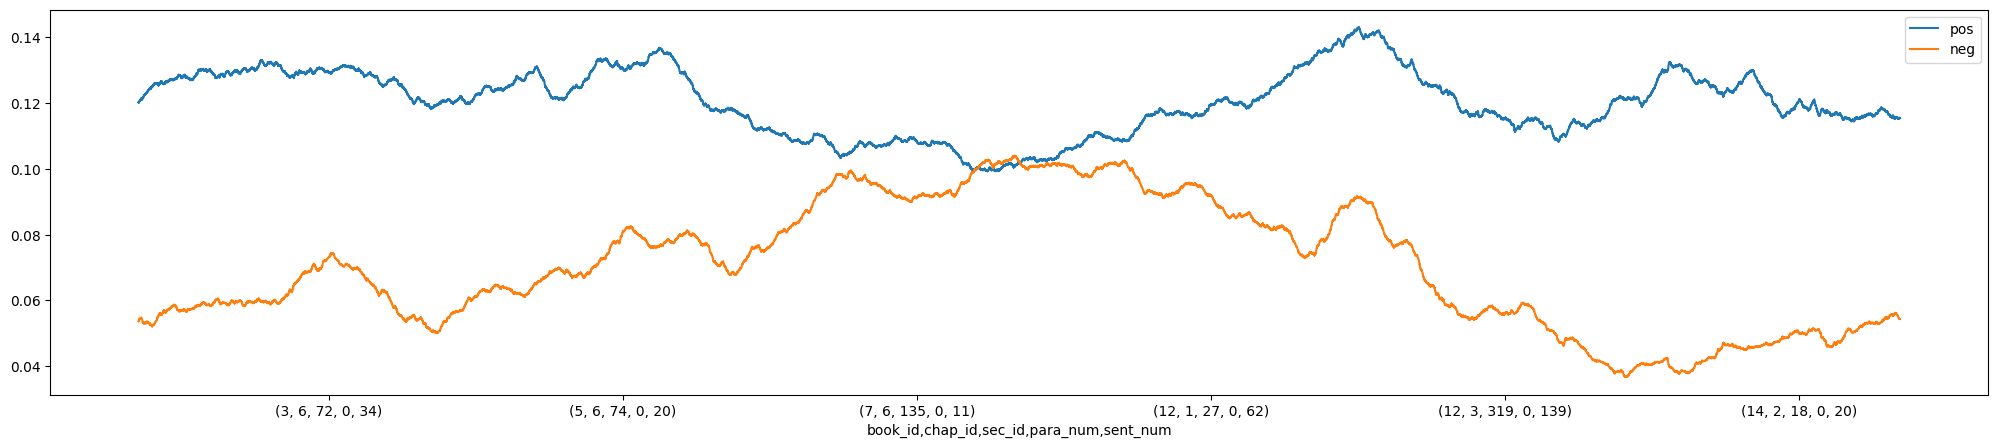

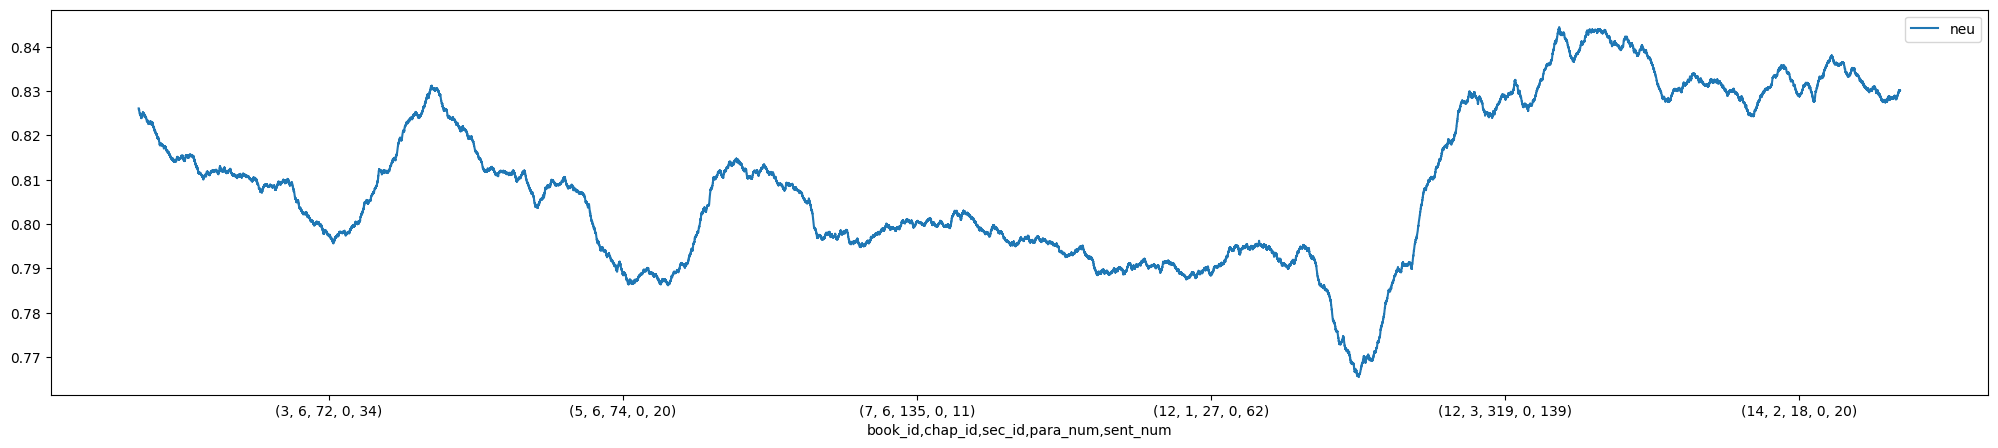

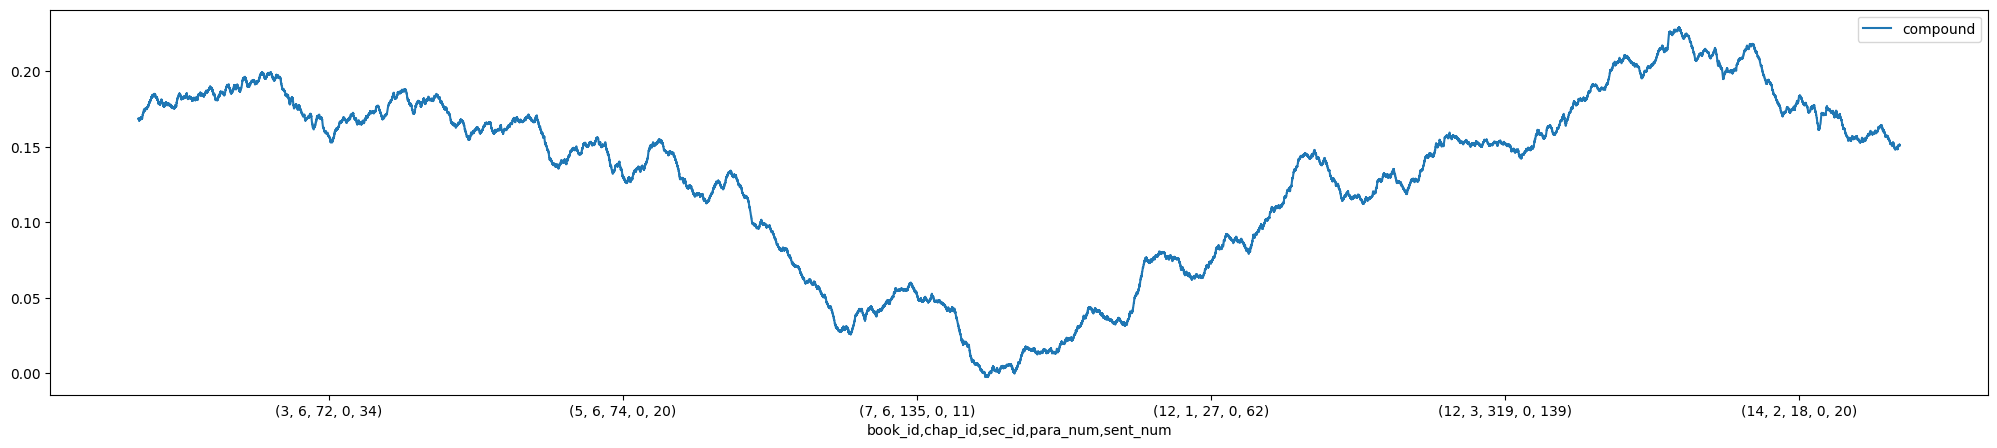

In [151]:
w = int(T_vader.shape[0] / 18)
T_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
T_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
T_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

In [153]:
import sys; sys.path.append("src/")
from hac2 import HAC

In [180]:
BOW_Keywords

,Keywords
chapter,
1.1,sanjaya hope vyasa chariot dwaipayana composed...
1.2,comes story history composed described vyasa i...
1.3,serpents aswins earrings wheel queen alms prec...
1.4,bhrigu rakshasa serpent curse agni ceremonies ...
1.5,kasyapa amrita garuda skies spake bird snake
...,...
15.2,penances vyasa gandhari deities fatherinlaw la...
15.3,gandhari sanjaya burnt fie conflagration retre...
16.1,vrishnis andhakas vrishni robbers ladies rama ...


In [188]:
EMOX = B[emo_cols].groupby(['book_id','chap_id']).mean().reset_index()
EMOX['chapter'] = EMOX.apply(lambda x: f"{int(x['book_id'])}.{int(x['chap_id'])}", axis=1)
EMOX = EMOX.drop(OHCO[:2], axis=1).set_index('chapter')
EMOX = EMOX.join(BOW_Keywords).reset_index().set_index(['chapter','Keywords'])
EMOX

,,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
chapter,Keywords,,,,,,,,,
1.1,sanjaya hope vyasa chariot dwaipayana composed puranas,0.000076,0.000134,0.000051,0.000084,0.000157,0.000082,0.000081,0.000161,0.000090
1.2,comes story history composed described vyasa incidents,0.000090,0.000098,0.000071,0.000118,0.000091,0.000109,0.000046,0.000108,-0.000050
1.3,serpents aswins earrings wheel queen alms preceptors,0.000087,0.000125,0.000113,0.000131,0.000144,0.000145,0.000064,0.000203,0.000008
1.4,bhrigu rakshasa serpent curse agni ceremonies history,0.000135,0.000190,0.000142,0.000224,0.000220,0.000165,0.000066,0.000230,0.000032
1.5,kasyapa amrita garuda skies spake bird snake,0.000047,0.000033,0.000038,0.000058,0.000035,0.000049,0.000017,0.000042,-0.000031
...,...,...,...,...,...,...,...,...,...,...
15.2,penances vyasa gandhari deities fatherinlaw ladies meeting,0.000045,0.000088,0.000038,0.000071,0.000104,0.000090,0.000038,0.000116,0.000051
15.3,gandhari sanjaya burnt fie conflagration retreat ganga,0.000121,0.000150,0.000120,0.000215,0.000141,0.000196,0.000067,0.000241,-0.000101
16.1,vrishnis andhakas vrishni robbers ladies rama carnage,0.000101,0.000056,0.000076,0.000114,0.000066,0.000115,0.000048,0.000059,-0.000065


In [189]:
EMOX.sort_values('sentiment').style.background_gradient(cmap='YlGnBu', axis=None)

,,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
chapter,Keywords,,,,,,,,,
3.17,misfortune rescued jayadratha markandeya hours unfortunate disgrace,0.001953,0.000242,0.001793,0.001644,0.000941,0.002240,0.000214,0.000960,-0.001519
3.2,rakshasa kamyaka waist vidura coppery fearful devour,0.000514,0.000127,0.000362,0.000515,0.000125,0.000276,0.000106,0.000125,-0.000547
9.2,combatants keen carnage arrow shafts carwarriors army,0.000159,0.000050,0.000086,0.000152,0.000053,0.000124,0.000055,0.000050,-0.000153
4.2,virata matsyas combat disguised descendants welltrained disguise,0.000709,0.000350,0.000229,0.000575,0.000595,0.000244,0.000355,0.000269,-0.000146
1.9,rakshasa sleeping sister woman flesh ghatotkacha teeth,0.000186,0.000108,0.000149,0.000236,0.000143,0.000129,0.000062,0.000131,-0.000118
3.14,attaineth subdued acquireth asceticism trouble vyasa misery,0.000409,0.000479,0.000513,0.000810,0.000497,0.000691,0.000153,0.000599,-0.000115
15.3,gandhari sanjaya burnt fie conflagration retreat ganga,0.000121,0.000150,0.000120,0.000215,0.000141,0.000196,0.000067,0.000241,-0.000101
3.10,serpent snake intellect sudra agastya serpents hermitage,0.000112,0.000077,0.000149,0.000236,0.000110,0.000126,0.000042,0.000146,-0.000094
5.8,suyodhana manliness dussasana sanjaya relying ally fool,0.000125,0.000045,0.000097,0.000116,0.000056,0.000084,0.000023,0.000089,-0.000083


<Figure size 640x480 with 0 Axes>

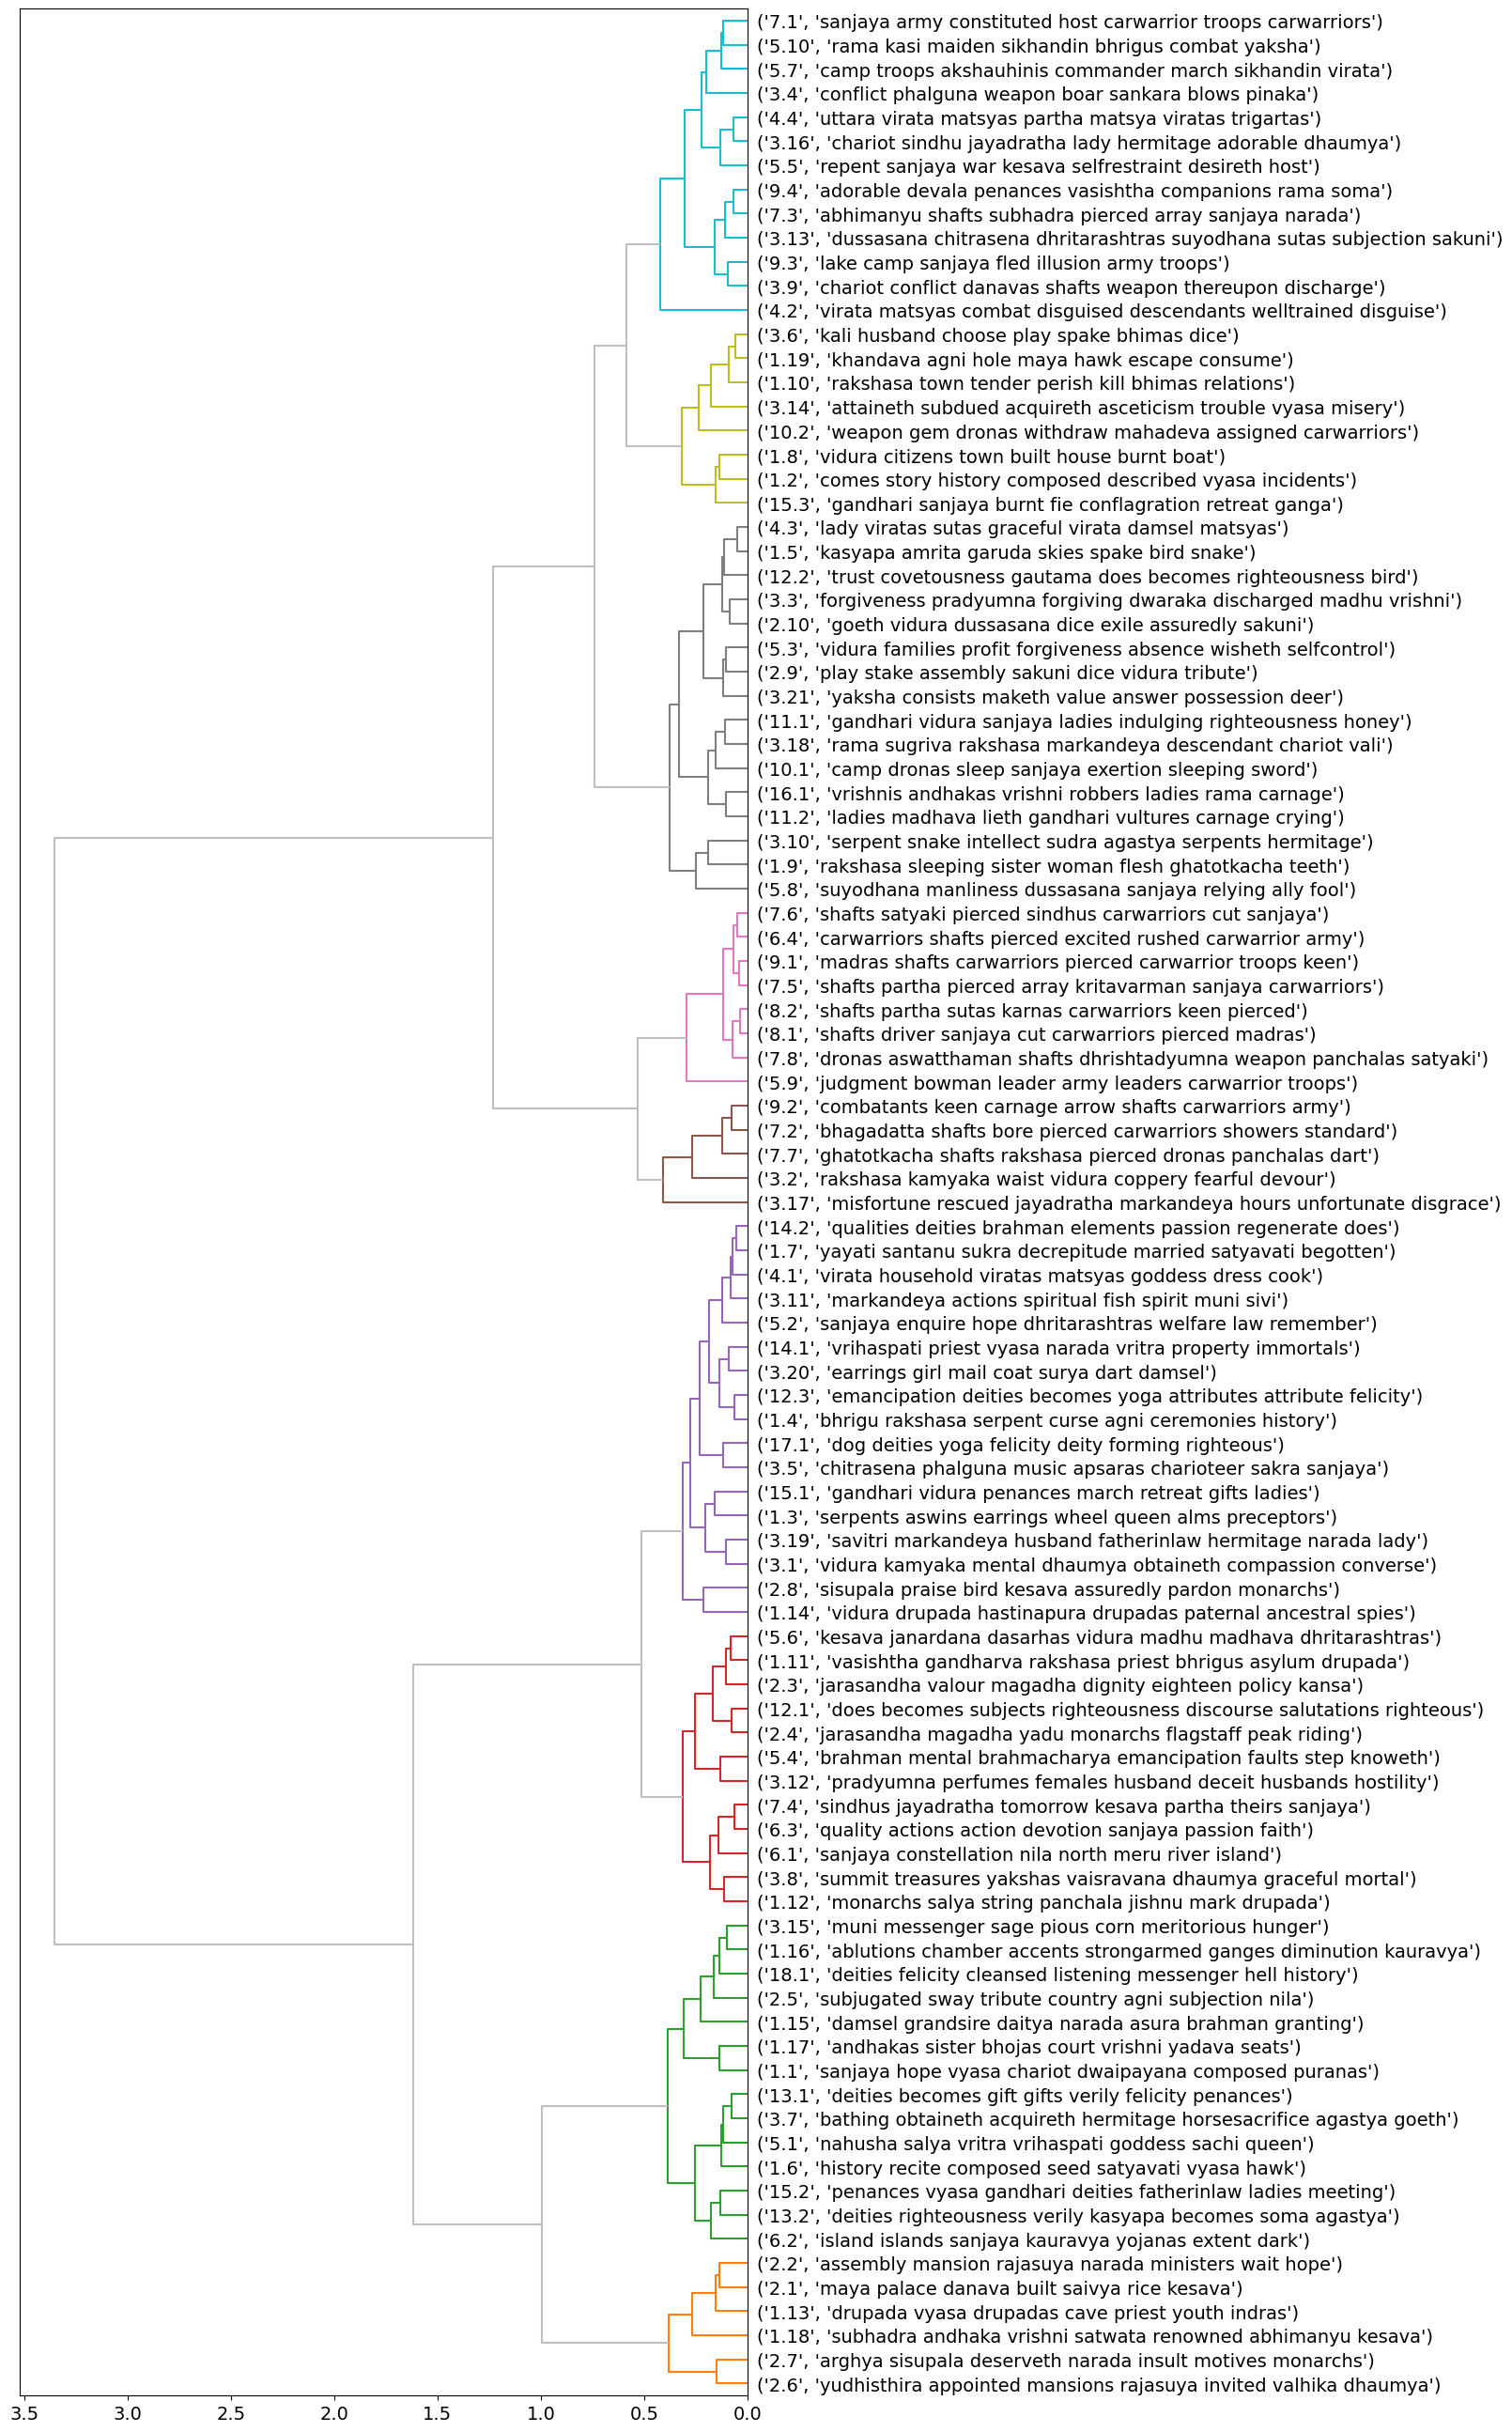

In [190]:
emo_tree = HAC(EMOX)
emo_tree.color_thresh=.5
emo_tree.plot()

In [191]:
B.to_csv(fr"{output_dir}/CHAP_BOW/{data_prefix}-SENTBOW.csv", sep="|")